In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
im_width = 256
im_height = 256

In [3]:
train_files = []
mask_files = glob('kaggle_3m/*/*_mask*')

for i in mask_files:
    train_files.append(i.replace('_mask',''))

print(train_files[:10])
print(mask_files[:10])

['kaggle_3m/TCGA_HT_7692_19960724/TCGA_HT_7692_19960724_12.tif', 'kaggle_3m/TCGA_HT_7692_19960724/TCGA_HT_7692_19960724_18.tif', 'kaggle_3m/TCGA_HT_7692_19960724/TCGA_HT_7692_19960724_6.tif', 'kaggle_3m/TCGA_HT_7692_19960724/TCGA_HT_7692_19960724_2.tif', 'kaggle_3m/TCGA_HT_7692_19960724/TCGA_HT_7692_19960724_1.tif', 'kaggle_3m/TCGA_HT_7692_19960724/TCGA_HT_7692_19960724_17.tif', 'kaggle_3m/TCGA_HT_7692_19960724/TCGA_HT_7692_19960724_13.tif', 'kaggle_3m/TCGA_HT_7692_19960724/TCGA_HT_7692_19960724_7.tif', 'kaggle_3m/TCGA_HT_7692_19960724/TCGA_HT_7692_19960724_8.tif', 'kaggle_3m/TCGA_HT_7692_19960724/TCGA_HT_7692_19960724_14.tif']
['kaggle_3m/TCGA_HT_7692_19960724/TCGA_HT_7692_19960724_12_mask.tif', 'kaggle_3m/TCGA_HT_7692_19960724/TCGA_HT_7692_19960724_18_mask.tif', 'kaggle_3m/TCGA_HT_7692_19960724/TCGA_HT_7692_19960724_6_mask.tif', 'kaggle_3m/TCGA_HT_7692_19960724/TCGA_HT_7692_19960724_2_mask.tif', 'kaggle_3m/TCGA_HT_7692_19960724/TCGA_HT_7692_19960724_1_mask.tif', 'kaggle_3m/TCGA_HT_76

In [4]:
df = pd.DataFrame(data={"filename": train_files, 'mask' : mask_files})
df_train, df_test = train_test_split(df,test_size = 0.1)
df_train, df_val = train_test_split(df_train,test_size = 0.2)
print(df_train.values.shape)
print(df_val.values.shape)
print(df_test.values.shape)

(2828, 2)
(708, 2)
(393, 2)


# **Data genertator, data augmentation and adjust data**

In [5]:
def train_generator(data_frame, batch_size, aug_dict,
        image_color_mode="rgb",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(256,256),
        seed=1):
    
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    
    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col = "filename",
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col = "mask",
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)
    
    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)

def adjust_data(img,mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return (img, mask)

# **loss function and metrics**

In [6]:
smooth=100

def dice_coef(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)
    And=K.sum(y_truef* y_predf)
    return((2* And + smooth) / (K.sum(y_truef) + K.sum(y_predf) + smooth))

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def jac_distance(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)

    return - iou(y_true, y_pred)

# **Unet**

In [7]:
def unet(input_size=(256,256,3)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(64, (3, 3), padding='same')(inputs)
    bn1 = Activation('relu')(conv1)
    conv1 = Conv2D(64, (3, 3), padding='same')(bn1)
    bn1 = BatchNormalization(axis=3)(conv1)
    bn1 = Activation('relu')(bn1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)

    conv2 = Conv2D(128, (3, 3), padding='same')(pool1)
    bn2 = Activation('relu')(conv2)
    conv2 = Conv2D(128, (3, 3), padding='same')(bn2)
    bn2 = BatchNormalization(axis=3)(conv2)
    bn2 = Activation('relu')(bn2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)

    conv3 = Conv2D(256, (3, 3), padding='same')(pool2)
    bn3 = Activation('relu')(conv3)
    conv3 = Conv2D(256, (3, 3), padding='same')(bn3)
    bn3 = BatchNormalization(axis=3)(conv3)
    bn3 = Activation('relu')(bn3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)

    conv4 = Conv2D(512, (3, 3), padding='same')(pool3)
    bn4 = Activation('relu')(conv4)
    conv4 = Conv2D(512, (3, 3), padding='same')(bn4)
    bn4 = BatchNormalization(axis=3)(conv4)
    bn4 = Activation('relu')(bn4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(bn4)

    conv5 = Conv2D(1024, (3, 3), padding='same')(pool4)
    bn5 = Activation('relu')(conv5)
    conv5 = Conv2D(1024, (3, 3), padding='same')(bn5)
    bn5 = BatchNormalization(axis=3)(conv5)
    bn5 = Activation('relu')(bn5)

    up6 = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bn5), conv4], axis=3)
    conv6 = Conv2D(512, (3, 3), padding='same')(up6)
    bn6 = Activation('relu')(conv6)
    conv6 = Conv2D(512, (3, 3), padding='same')(bn6)
    bn6 = BatchNormalization(axis=3)(conv6)
    bn6 = Activation('relu')(bn6)

    up7 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(bn6), conv3], axis=3)
    conv7 = Conv2D(256, (3, 3), padding='same')(up7)
    bn7 = Activation('relu')(conv7)
    conv7 = Conv2D(256, (3, 3), padding='same')(bn7)
    bn7 = BatchNormalization(axis=3)(conv7)
    bn7 = Activation('relu')(bn7)

    up8 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(bn7), conv2], axis=3)
    conv8 = Conv2D(128, (3, 3), padding='same')(up8)
    bn8 = Activation('relu')(conv8)
    conv8 = Conv2D(128, (3, 3), padding='same')(bn8)
    bn8 = BatchNormalization(axis=3)(conv8)
    bn8 = Activation('relu')(bn8)

    up9 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(bn8), conv1], axis=3)
    conv9 = Conv2D(64, (3, 3), padding='same')(up9)
    bn9 = Activation('relu')(conv9)
    conv9 = Conv2D(64, (3, 3), padding='same')(bn9)
    bn9 = BatchNormalization(axis=3)(conv9)
    bn9 = Activation('relu')(bn9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(bn9)

    return Model(inputs=[inputs], outputs=[conv10])

# **Training**

In [8]:
EPOCHS = 150
BATCH_SIZE = 32
learning_rate = 1e-4

In [9]:
train_generator_args = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')
train_gen = train_generator(df_train, BATCH_SIZE,
                                train_generator_args,
                                target_size=(im_height, im_width))
    
test_gener = train_generator(df_val, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))
    
model = unet(input_size=(im_height, im_width, 3))


opt = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None,amsgrad=False)
model.compile(optimizer=opt, loss=dice_coef_loss, metrics=["binary_accuracy", iou, dice_coef])

callbacks = [ModelCheckpoint('unet_brain_mri_seg.hdf5', verbose=1, save_best_only=True)]


In [10]:
model = load_model('unet_brain_mri_seg.hdf5', custom_objects={'dice_coef_loss': dice_coef_loss, 'iou': iou, 'dice_coef': dice_coef})

In [11]:
test_gen = train_generator(df_test, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))
results = model.evaluate(test_gen, steps=len(df_test) / BATCH_SIZE)
print("Test lost: ",results[0])
print("Test IOU: ",results[1])
print("Test Dice Coefficent: ",results[2])

Found 393 validated image filenames.
Found 393 validated image filenames.
12/12 [==============================] - 175s 14s/step - loss: -0.9091 - binary_accuracy: 0.9983 - iou: 0.8374 - dice_coef: 0.9108
Test lost:  -0.9090706706047058
Test IOU:  0.9983133673667908
Test Dice Coefficent:  0.8373531699180603


1/1 [==============================] - 1s 829ms/step


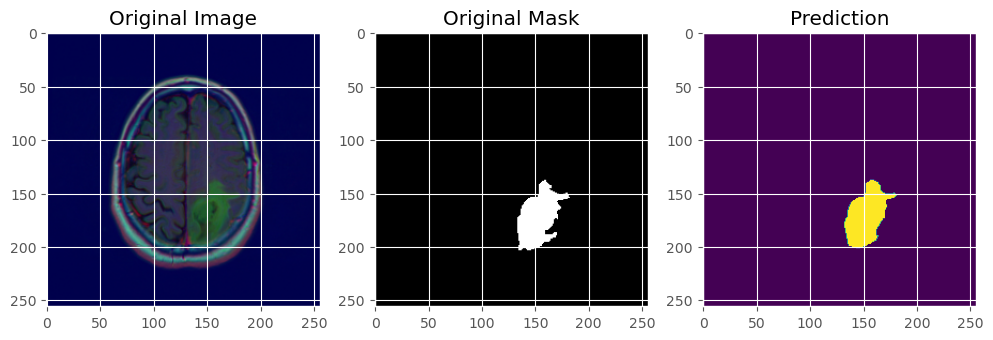

1/1 [==============================] - 0s 398ms/step


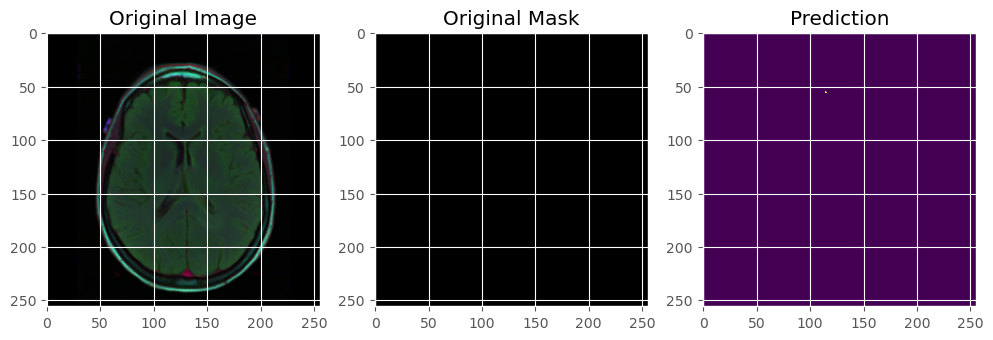

1/1 [==============================] - 0s 451ms/step


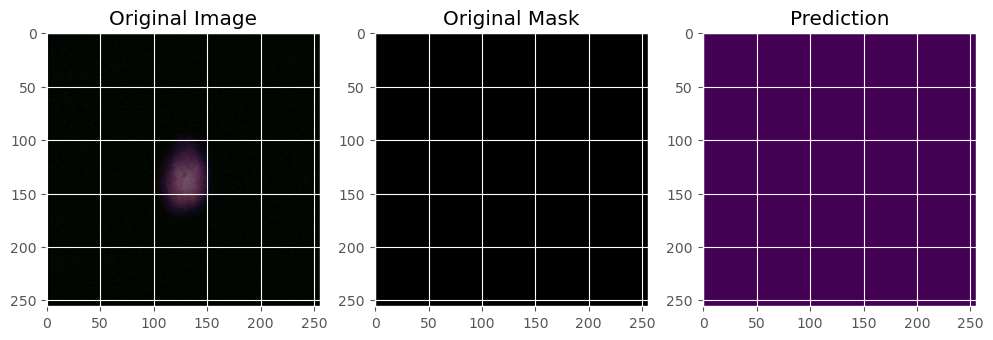

1/1 [==============================] - 0s 423ms/step


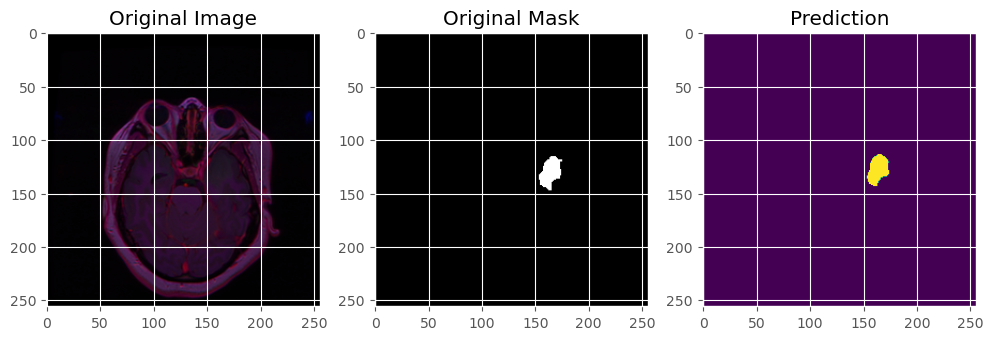

1/1 [==============================] - 0s 443ms/step


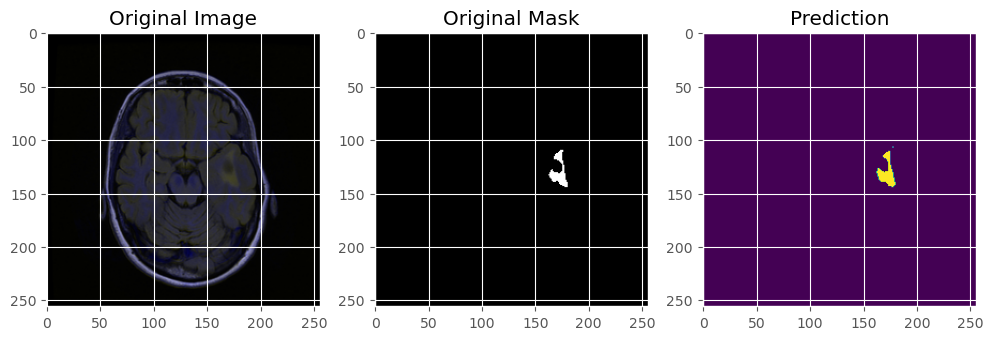

1/1 [==============================] - 0s 369ms/step


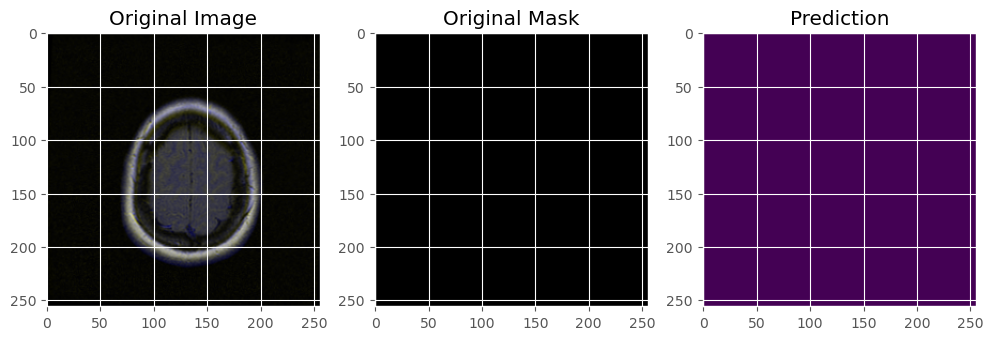

1/1 [==============================] - 0s 428ms/step


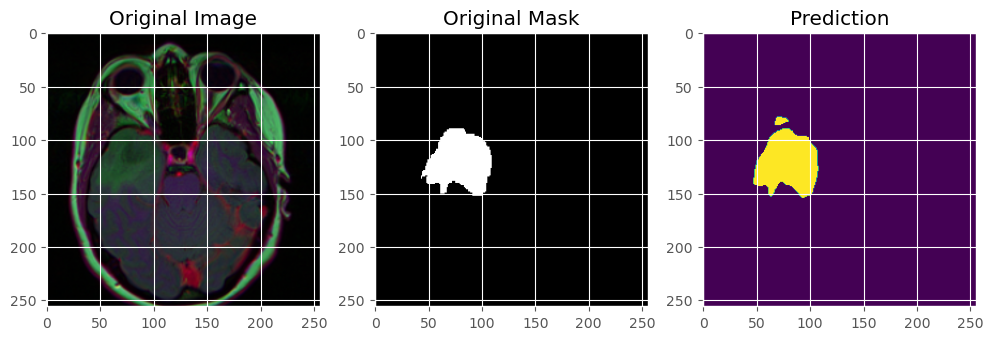

1/1 [==============================] - 0s 384ms/step


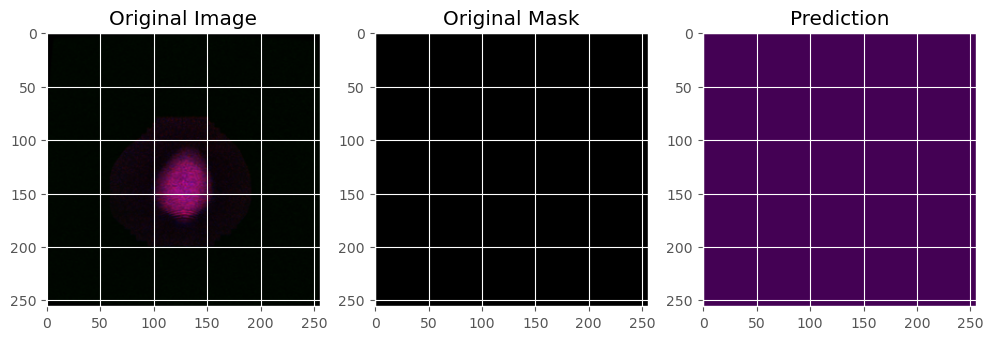

1/1 [==============================] - 0s 394ms/step


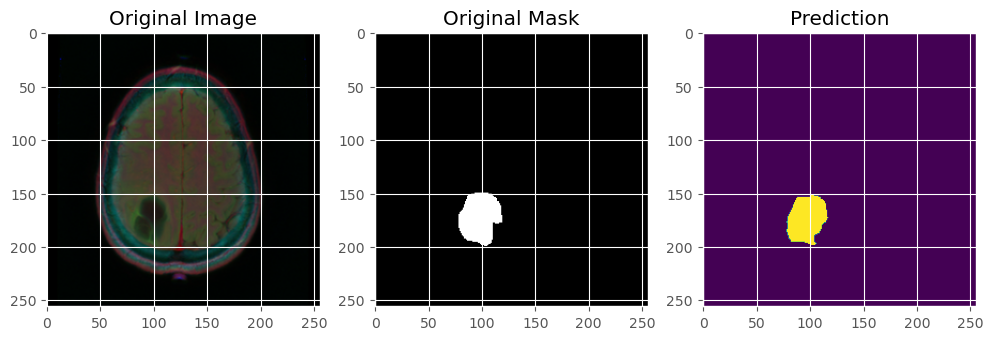

1/1 [==============================] - 0s 429ms/step


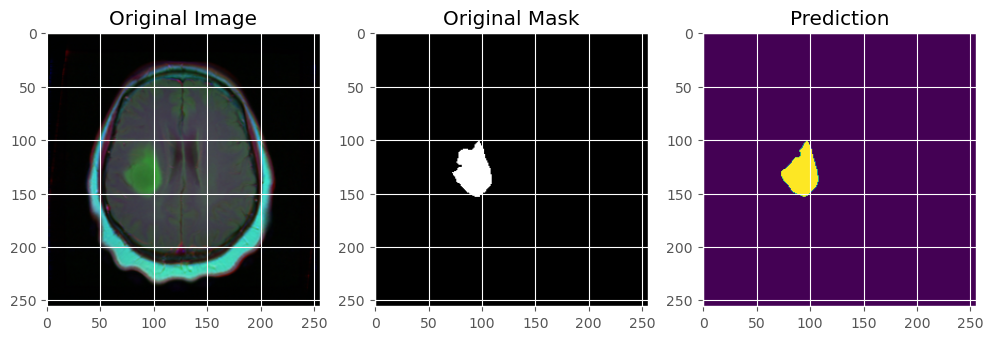

1/1 [==============================] - 0s 363ms/step


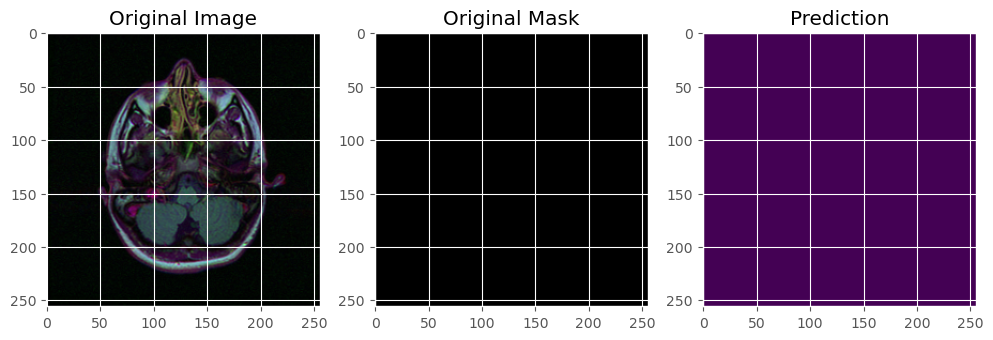

1/1 [==============================] - 0s 403ms/step


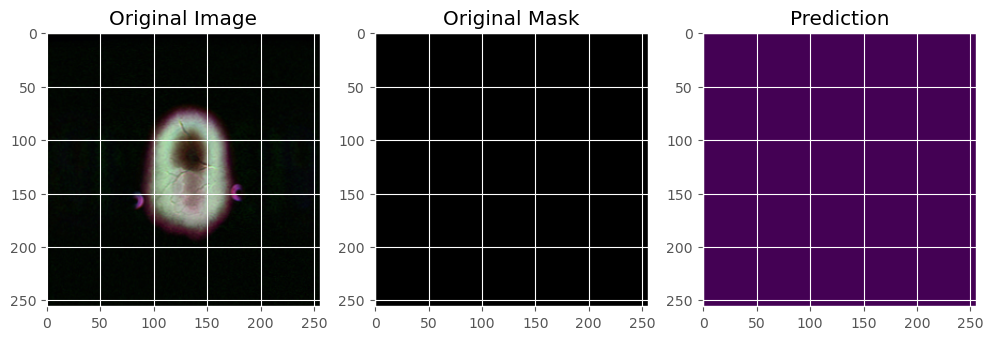

1/1 [==============================] - 0s 392ms/step


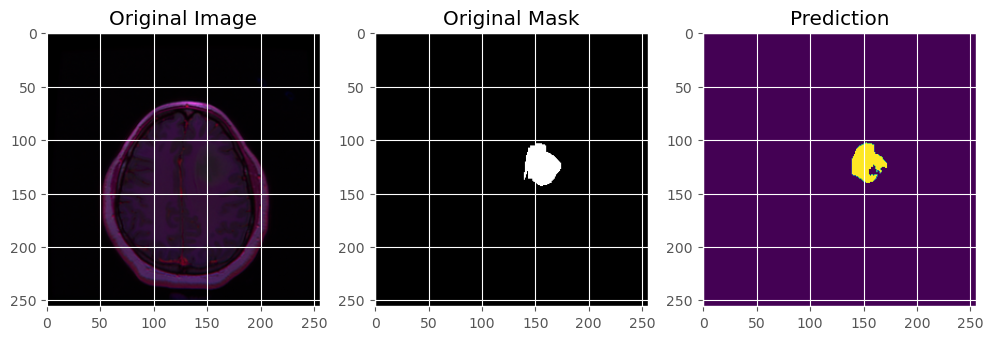

1/1 [==============================] - 0s 352ms/step


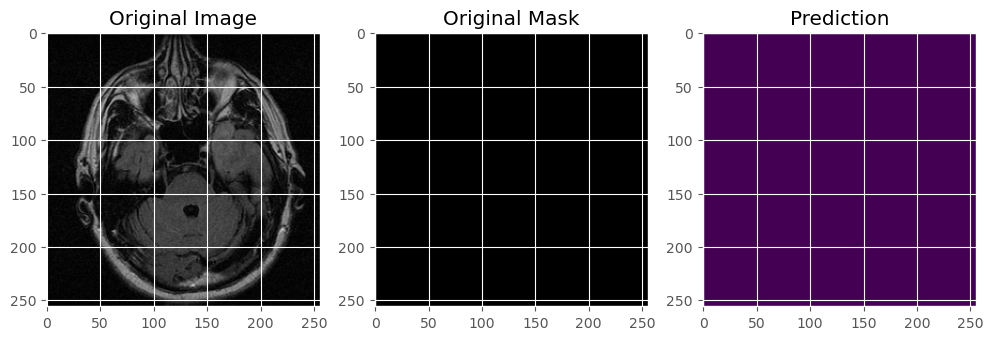

1/1 [==============================] - 0s 439ms/step


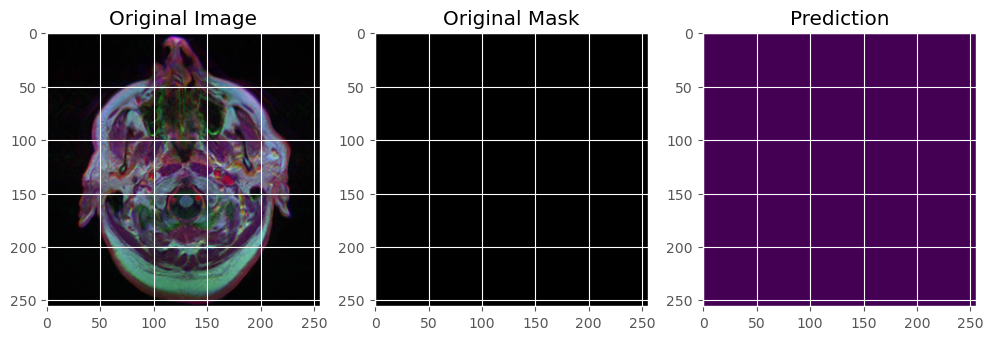

1/1 [==============================] - 0s 351ms/step


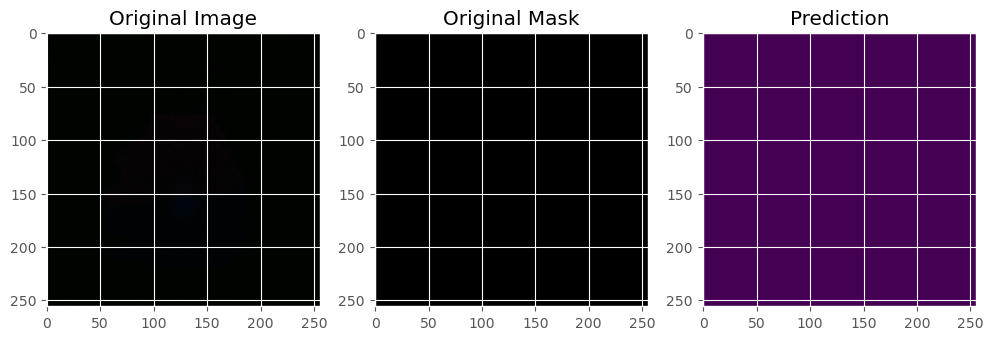

1/1 [==============================] - 0s 417ms/step


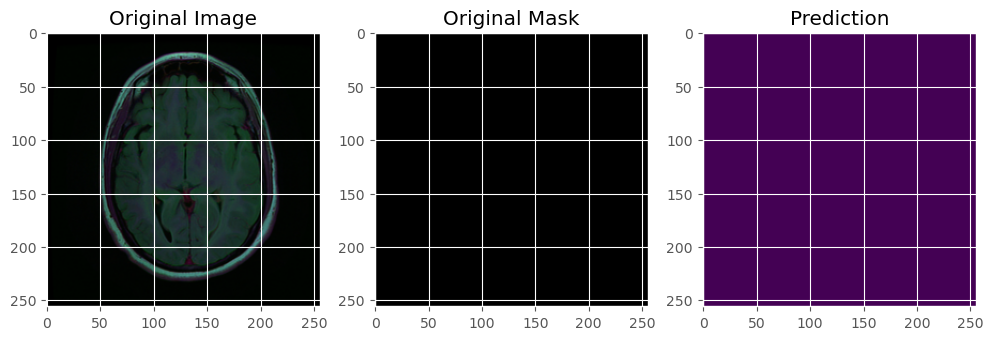

1/1 [==============================] - 0s 391ms/step


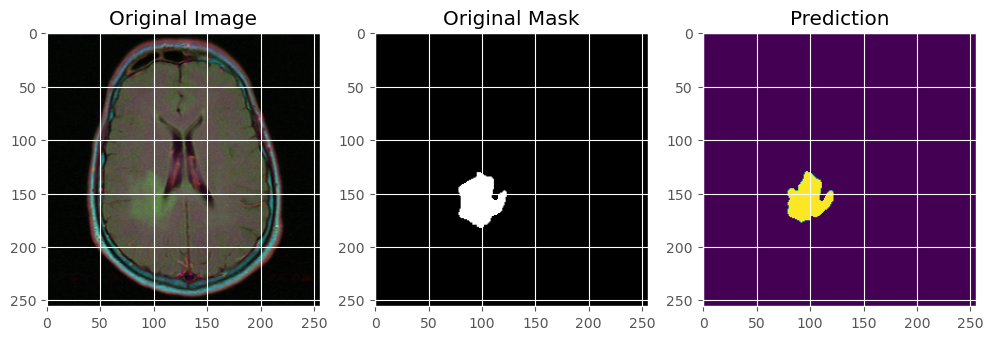

1/1 [==============================] - 0s 465ms/step


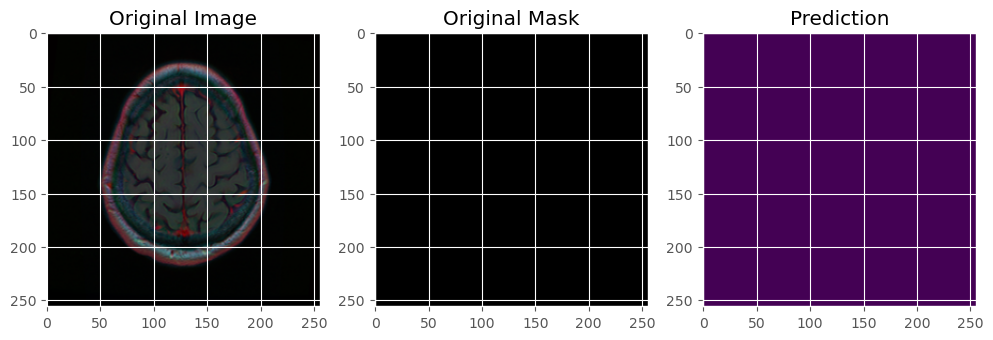

1/1 [==============================] - 0s 407ms/step


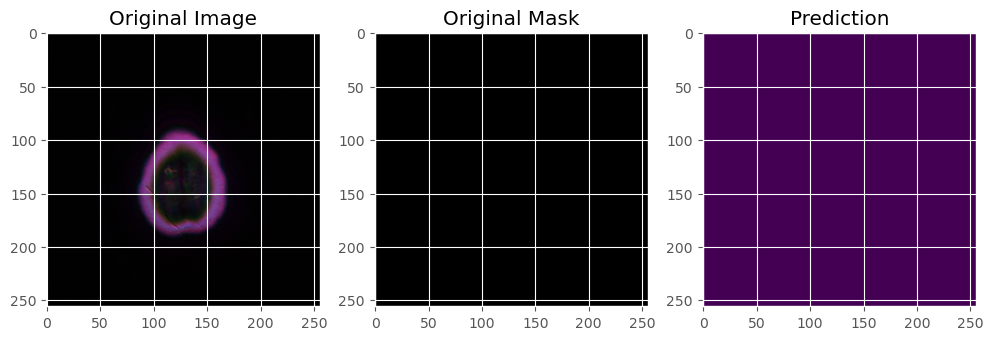

1/1 [==============================] - 0s 352ms/step


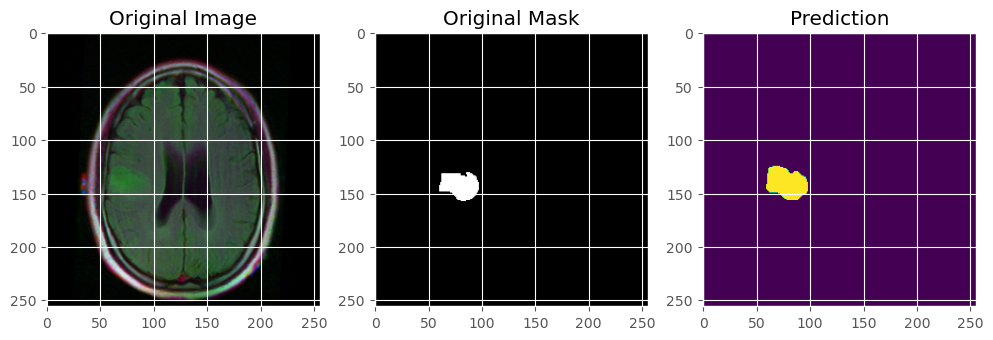

1/1 [==============================] - 0s 386ms/step


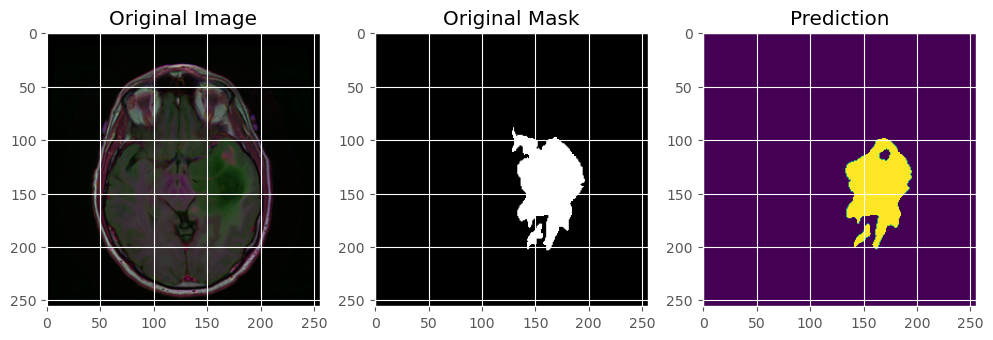

1/1 [==============================] - 0s 487ms/step


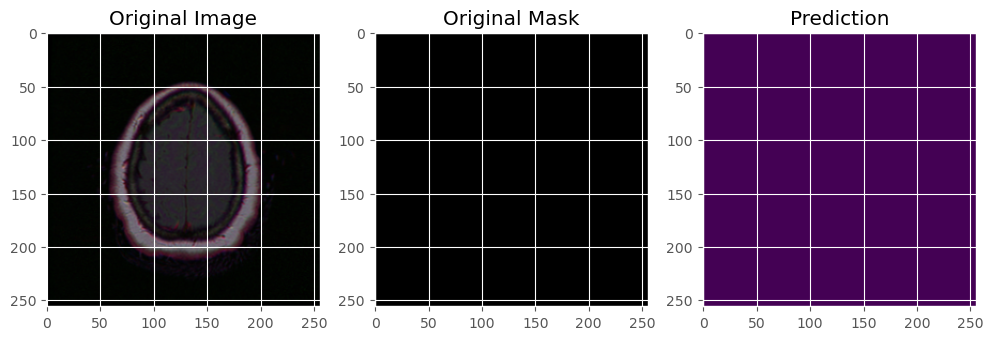

1/1 [==============================] - 0s 396ms/step


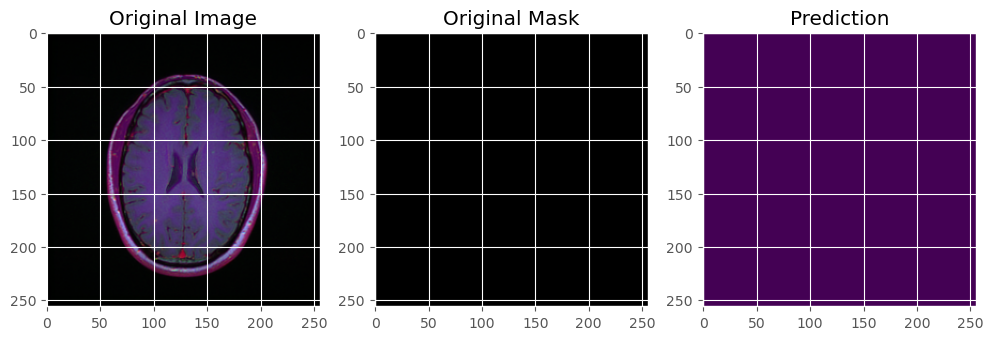

1/1 [==============================] - 0s 450ms/step


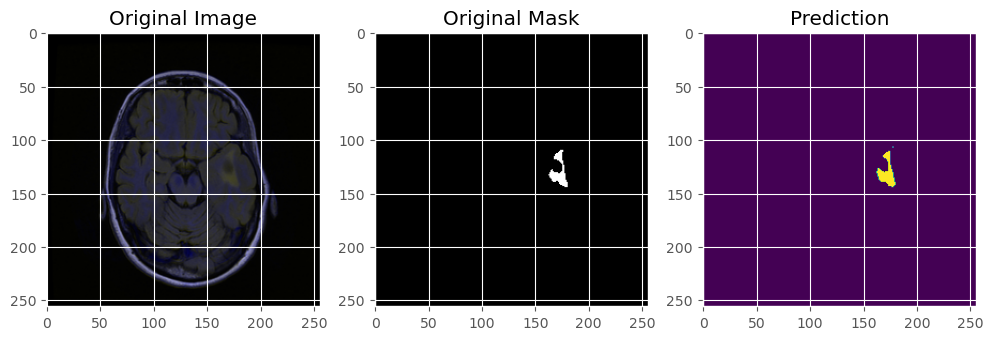

1/1 [==============================] - 0s 394ms/step


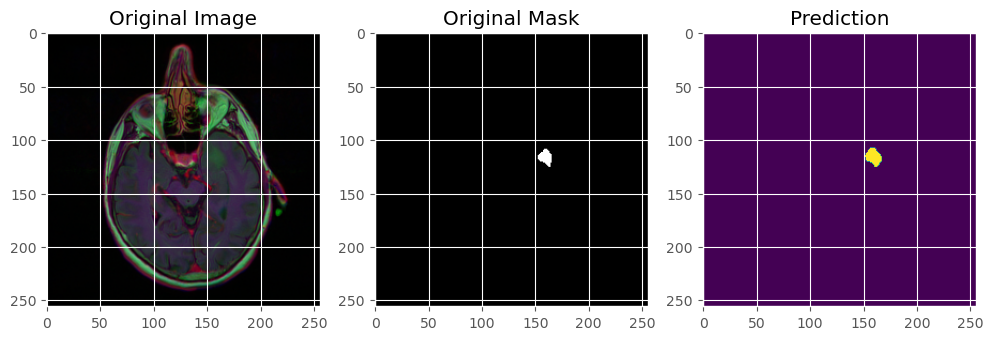

1/1 [==============================] - 0s 369ms/step


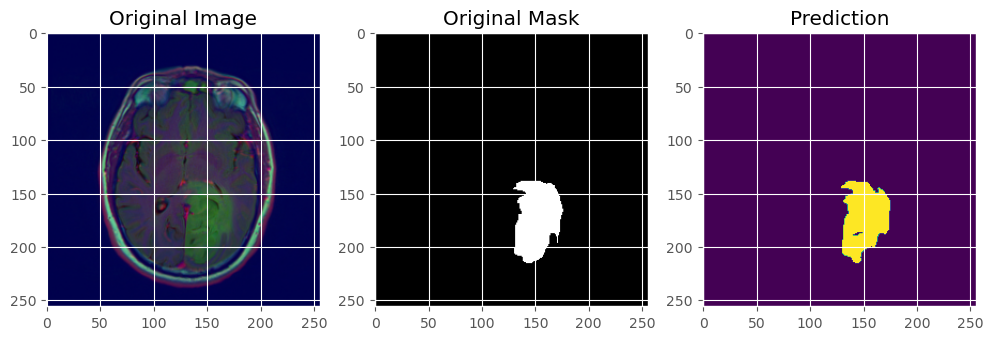

1/1 [==============================] - 0s 368ms/step


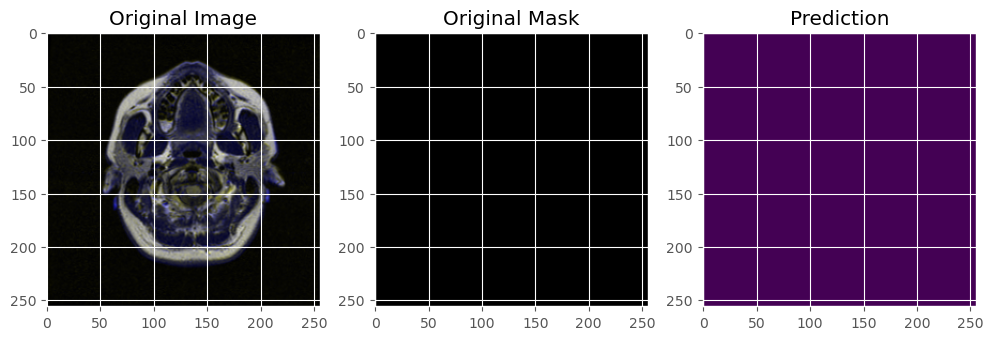

1/1 [==============================] - 0s 403ms/step


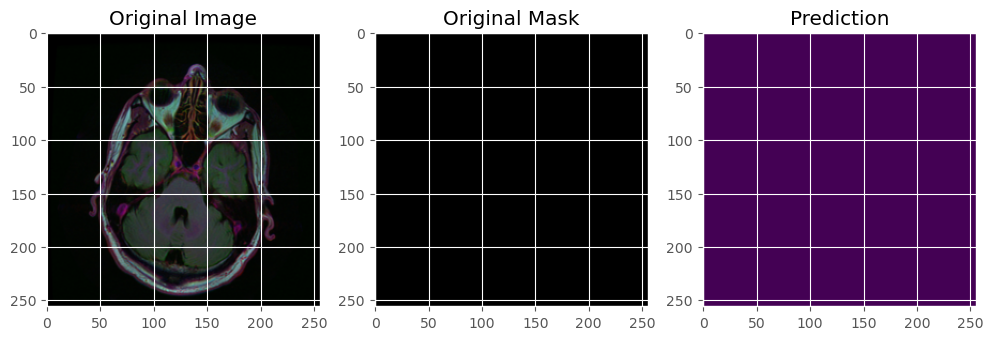

1/1 [==============================] - 0s 389ms/step


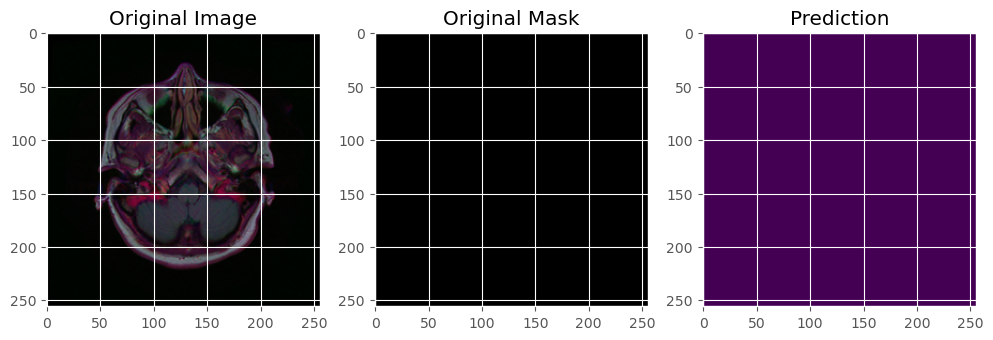

In [12]:
for i in range(30):
    index=np.random.randint(1,len(df_test.index))
    img = cv2.imread(df_test['filename'].iloc[index])
    img = cv2.resize(img ,(im_height, im_width))
    img = img / 255
    img = img[np.newaxis, :, :, :]
    pred=model.predict(img)

    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')
    plt.subplot(1,3,2)
    plt.imshow(np.squeeze(cv2.imread(df_test['mask'].iloc[index])))
    plt.title('Original Mask')
    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(pred) > .5)
    plt.title('Prediction')
    plt.show()

Enter the path to the TIFF image: /home/mostafatarek/Videos/Brain Tumor Segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_2.tif
1/1 [==============================] - 1s 616ms/step


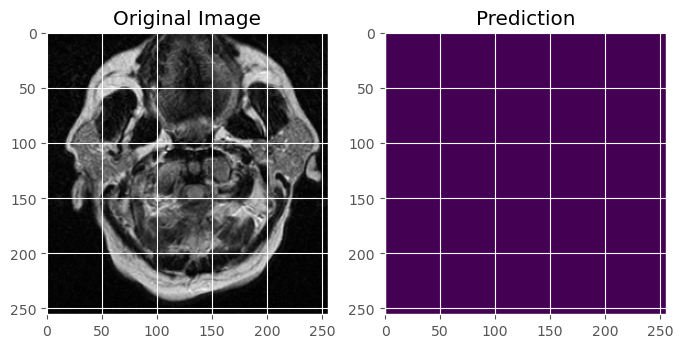

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from PIL import Image

# Define your image dimensions
im_height, im_width = 256, 256

# User provides the image path
user_image_path = input("Enter the path to the TIFF image: ")

# Load the image using PIL
img = Image.open(user_image_path)

# Convert to numpy array
img_array = np.array(img)

# Assuming you need to extract a 2D slice (you may need to adapt this based on your data)
slice_index = img_array.shape[2] // 2  # Use the middle slice for simplicity
img_slice = img_array[:, :, slice_index]

# Resize and normalize the image
img_slice = cv2.resize(img_slice, (im_height, im_width))
img_slice = img_slice / np.max(img_slice)

# Convert single-channel image to three channels
img_slice_rgb = np.stack((img_slice,) * 3, axis=-1)

# Add a batch dimension
img_slice_rgb = img_slice_rgb[np.newaxis, :, :, :]

# Make predictions using the model
pred = model.predict(img_slice_rgb)

# Plot the original image and the model's prediction
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.imshow(np.squeeze(img_slice_rgb))
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(np.squeeze(pred) > 0.5)
plt.title('Prediction')

plt.show()


Enter the path to the TIFF image: 
  @media print {
    .ms-editor-squiggles-container {
      display:none !important;
    }
  }
  .ms-editor-squiggles-container {
    all: initial;
  }/home/mostafatarek/Videos/Brain Tumor Segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_13.tif
1/1 [==============================] - 0s 377ms/step


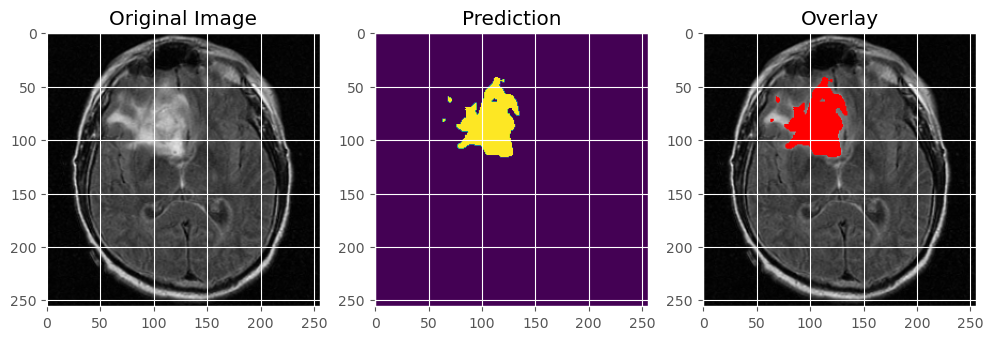

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from PIL import Image

im_height, im_width = 256, 256

user_image_path = input("Enter the path to the TIFF image: ")

img = Image.open(user_image_path)

img_array = np.array(img)

slice_index = img_array.shape[2] // 2  # Use the middle slice for simplicity
img_slice = img_array[:, :, slice_index]

img_slice = cv2.resize(img_slice, (im_height, im_width))
img_slice = img_slice / np.max(img_slice)

img_slice_rgb = np.stack((img_slice,) * 3, axis=-1)

img_slice_rgb = img_slice_rgb[np.newaxis, :, :, :]

pred = model.predict(img_slice_rgb)

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(np.squeeze(img_slice_rgb))
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(np.squeeze(pred) > 0.5)
plt.title('Prediction')

plt.subplot(1, 3, 3)
overlay = np.squeeze(img_slice_rgb.copy())
overlay[np.squeeze(pred) > 0.5] = [1, 0, 0]  # Red overlay where the mask is predicted
plt.imshow(overlay)
plt.title('Overlay')

plt.show()


Enter the path to the TIFF image: 
  @media print {
    .ms-editor-squiggles-container {
      display:none !important;
    }
  }
  .ms-editor-squiggles-container {
    all: initial;
  }/home/mostafatarek/Videos/Brain Tumor Segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_2.tif
1/1 [==============================] - 0s 489ms/step


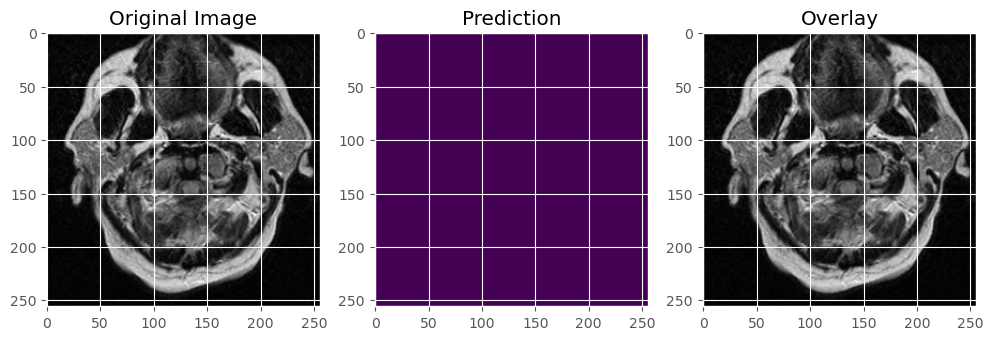

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from PIL import Image

im_height, im_width = 256, 256

user_image_path = input("Enter the path to the TIFF image: ")

img = Image.open(user_image_path)

img_array = np.array(img)

slice_index = img_array.shape[2] // 2  # Use the middle slice for simplicity
img_slice = img_array[:, :, slice_index]

img_slice = cv2.resize(img_slice, (im_height, im_width))
img_slice = img_slice / np.max(img_slice)

img_slice_rgb = np.stack((img_slice,) * 3, axis=-1)

# Add a batch dimension
img_slice_rgb = img_slice_rgb[np.newaxis, :, :, :]

pred = model.predict(img_slice_rgb)

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(np.squeeze(img_slice_rgb))
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(np.squeeze(pred) > 0.5)
plt.title('Prediction')

plt.subplot(1, 3, 3)
overlay = np.squeeze(img_slice_rgb.copy())
overlay[np.squeeze(pred) > 0.5] = [1, 0, 0] 
plt.imshow(overlay)
plt.title('Overlay')

plt.show()
